
# `12` Plotting Part 1


We may want to make a boxplot figure for the three species and how they differ in flipper length. Hopefully you are a little familiar with ggplot so this isn't new to you. Here is a default boxplot from ggplot2:




In [6]:
install.packages(c("ggplot2", "palmerpenguins", "janitor", "dplyr"))

# Load the packages:
library(ggplot2)
library(palmerpenguins)
library(janitor)
library(dplyr)

# Load the function definitions
source("functions/cleaning.r")


# Save the raw data:
write.csv(penguins_raw, "data/penguins_raw.csv")

# Check the raw data:
names(penguins_raw)

# Clean the data:
penguins_clean <- penguins_raw %>%
    clean_column_names() %>%
    shorten_species() %>%
    remove_empty_columns_rows()

# Check the cleaned data:
names(penguins_clean)

# Save cleaned data:
write.csv(penguins_clean, "data/penguins_clean.csv")

# Filter the data:
flipper_data <- penguins_clean %>%
    subset_columns(c("flipper_length_mm", "species","sex")) %>%
    remove_NA()

head(flipper_data)


# Ignore this, it's just to make the plots look nicer in my notebook:
options(repr.plot.width = 4, repr.plot.height = 4, repr.plot.res = 300)


Installing packages into ‘/opt/homebrew/lib/R/4.3/site-library’
(as ‘lib’ is unspecified)



[1] "studyName"           "Sample Number"       "Species"            
 [4] "Region"              "Island"              "Stage"              
 [7] "Individual ID"       "Clutch Completion"   "Date Egg"           
[10] "Culmen Length (mm)"  "Culmen Depth (mm)"   "Flipper Length (mm)"
[13] "Body Mass (g)"       "Sex"                 "Delta 15 N (o/oo)"  
[16] "Delta 13 C (o/oo)"   "Comments"

[1] "study_name"        "sample_number"     "species"          
 [4] "region"            "island"            "stage"            
 [7] "individual_id"     "clutch_completion" "date_egg"         
[10] "culmen_length_mm"  "culmen_depth_mm"   "flipper_length_mm"
[13] "body_mass_g"       "sex"               "delta_15_n_o_oo"  
[16] "delta_13_c_o_oo"   "comments"

flipper_length_mm,species,sex
<dbl>,<chr>,<chr>
181,Adelie,MALE
186,Adelie,FEMALE
195,Adelie,FEMALE
193,Adelie,FEMALE
190,Adelie,MALE
181,Adelie,FEMALE


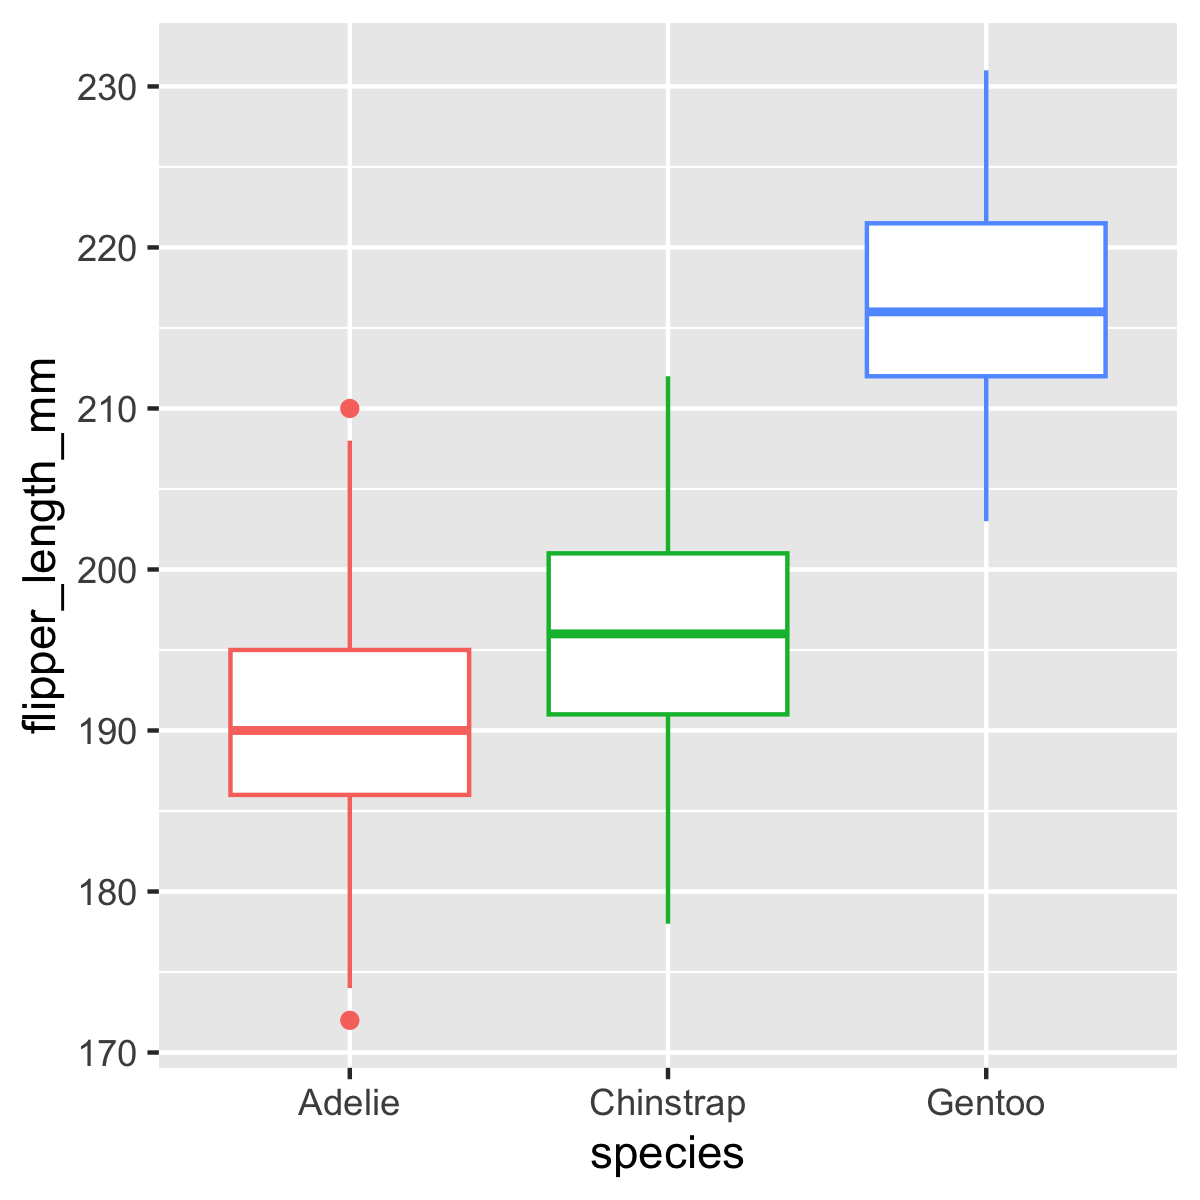

In [7]:

# Create boxplot of flipper length by species
flipper_boxplot <- ggplot(data = flipper_data, 
                          aes(x = species, 
                              y = flipper_length_mm)) +
                          geom_boxplot(aes(color = species), show.legend = FALSE)

flipper_boxplot


## Oh no, it's ugly. 

There are lots of problems with this figure design that make it difficult to understand, and it looks ugly. We can use settings to improve its readability. 

- Make the y axis readable
- Make the boxplots narrower

The penguin graphic above associates a colour with each penguin. We would like to follow that convention. 

We also know this data set is relatively small (n=344) and so we can also plot the raw data over the top of the results. 

---

## <span style='background:yellow'> Exercise 04 (15 mins) </span>

Try to make your plot look like the one below. Below are some hints, remember to google these to find out what they do and try them out.
- `"darkorange" "purple" "cyan4"`
- `scale_colour_manual`
- `geom_jitter`
- `scale_x_discrete`

The grey background and grid lines are also unsuitable, but we will fix that later so don't worry about those for now.

---

<img src="figures/grey_figure.png" alt="Drawing" style="width: 600px;"/>

I will now talk through some of the more tricky parts of this exercise. 

### Transparency

When considering how transparent your elements are, the terminology is its `alpha` value, where 1 is opaque and 0 is completely transparent. Here I gave the `geom_jitter` an `alpha = 0.3` setting.

### Random Seed

`geom_jitter` plots the data in y. However, if it plotted in x, all the markers would exist in a straight line. The function gives each point a random x value within a certain width to make the markers more visible. In this case the x variable for the markers is therefore meaningless. 

The problem with asking a computer to generate randomness is a) it is not truly random b) it is not reproducible! If you wanted to make sure you produce the same image every time, instead your markers would differ each time. In this example, it really doesn't matter, but any random aspect of your analysis should be repeatable.

To do this, I specified a `random_seed = 0`. This means it will make the same randomness every time I run it. 

### My font sizes are the wrong size! 

We will cover this in the next section.


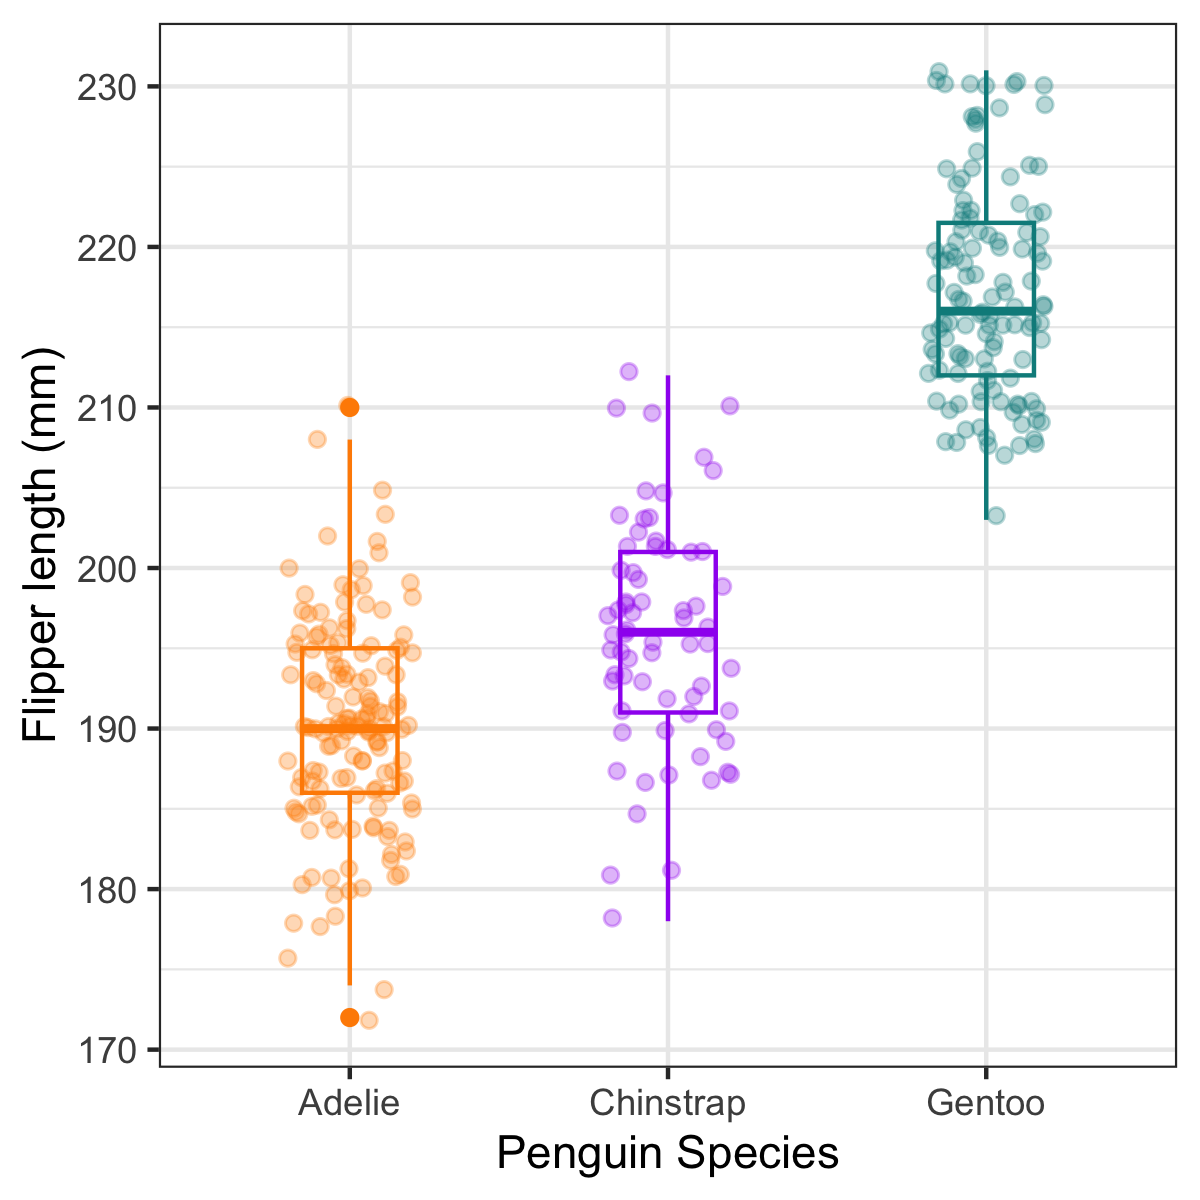

In [74]:
flipper_boxplot <- ggplot(data = flipper_data, aes(x = species, y = flipper_length_mm)) +
  geom_boxplot(aes(color = species), width = 0.3, show.legend = FALSE) +
  geom_jitter(aes(color = species), alpha = 0.3, show.legend = FALSE, position = position_jitter(width = 0.2, seed = 0)) +
  scale_color_manual(values = c("darkorange","purple","cyan4")) +
  scale_x_discrete(labels=c("Adelie","Chinstrap","Gentoo")) +
  labs(x = "Penguin Species",
       y = "Flipper length (mm)") +
  theme_bw()

flipper_boxplot

## `13` Creating `plotting.r`

We're going to move this code to its own file. 

It's not good to have this plotting code stored in this notebook as it is far too tempting for me to tweak settings on it later.

> Why is that a bad thing?

Like before, I can make that code into a function and put it from a file called `plotting.r` in the `functions` folder. 



Again, writing this does exactly nothing. I will need to call it. 

I just have to tell R where to look and can call the function from here. I don't need to look at the code in this notebook. 


## `14` Saving Figures


Lets save the figure as a file. First, make a new folder called `figures/`:

<img src="image/directory_012.png" alt="Drawing" style="width: 400px;"/>


One of the traps with making figures is to try and do everything manually. Some aspects, like the colours and widths of the boxplots did require manual settings. However, it would have been easy spend hours changing the grid colours and background colours myself as well, but `theme_bw` does that for me.

When it comes to the size of your figures, you can fall into a similar trap. Manually changing font sizes is not fun or useful!

If you've ever tried to save your figures from R, you may then get into a muddle trying to make sure the size is reasonable for your poster/report/printing out. It is tempting to start editing the text sizes yourself.

The problem is not your font sizes. The problem is to do with **size**, **scale**, and **resolution**. 

### Size, scale, and resolution. 

I like using the library `ragg` to deal with this counter intuitive problem. 

First we can consider size as it is the easiest to understand. Imagine you are printing a picture, the size tells you how big that image is in physical dimensions. 

So we can use this library to save a `png` file and we want our image to be 1000 x 1000 pixels, so we can specify that. 

In [10]:
install.packages('ragg')
library(ragg)

# Create the figure object
flipper_boxplot <- plot_flipper_figure(flipper_data)

# Call the function that will save it as a .png
agg_png("figures/first_size.png", 
        width = 500, height = 500, units = "px")
flipper_boxplot
dev.off()

Installing package into ‘/opt/homebrew/lib/R/4.3/site-library’
(as ‘lib’ is unspecified)



ERROR: Error in plot_flipper_figure(flipper_data): could not find function "plot_flipper_figure"


If we open the file, it looks like this:

<img src="https://i.imgur.com/Rb1B0G4.png" alt="Drawing" style="width: 400px;"/>

We see this has not worked as we expected, the image fuzzy. The figure is the physical size we want, in this case we want it to be 500 by 500 pixels on the screen. However, if we zoom in we can see it is pixelated. 

### What we need to do is also specify the resolution.

The default setting is a resolution of 72, which means how many pixels will be used to draw the images in the given area. For fun, lets reduce this down to 10.


In [83]:
agg_png("figures/same_size_lowres.png", 
        width = 600, height = 600, units = "px", 
        res=10,
        scaling = )
flipper_boxplot
dev.off()

pdf 
  2

<img src="https://i.imgur.com/DiQ4hHe.png" alt="Drawing" style="width: 400px;"/>

The image is the same physical size, but there are very few pixels now.

Lets bump this up to a reasonable number.

In [84]:
agg_png("figures/same_size_highres.png", 
        width = 600, height = 600, units = "px",res=300)
flipper_boxplot
dev.off()

pdf 
  2

<img src="https://i.imgur.com/CeKNx8H.png" alt="Drawing" style="width: 400px;"/>

Okay, the problem isn't that it's pixellated! But the problem is that it's not printing as we expect and some elements are far too large. Remember, the image is still the same dimensions, so the issue here is not the size. 

### Instead the problem is the scale. 

In [85]:
agg_png("figures/same_size_highres_scalehalf.png", 
        width = 500, height = 500, units = "px",res=300, scaling = 0.5)
flipper_boxplot
dev.off()

pdf 
  2

<img src="https://i.imgur.com/kxmFQYg.png" alt="Drawing" style="width: 400px;"/>


## `15` Changing Size/Resolution/Scale for Real World Uses

The previous example was just an exercise, but now we can apply this to a classic problem -- how do I make my figure visible for a powerpoint presentation or poster? You may have seen horrible examples of this were people put figures meant for a research paper in powerpoint and you can't read the labels. 

> Remember! The solution is not to change the font sizes manually!

We don't usually think about things in pixels, so instead we can specify our new figure using centimetres instead. Here I'm putting it in the proper `figures/` folder.

In [86]:
agg_png("figures/fig01_15x15.png", 
        width = 15, height = 15, units = "cm", res = 600, scaling = 1.4)
flipper_boxplot
dev.off()


pdf 
  2

<img src="https://i.imgur.com/w6pj7In.png" alt="Drawing" style="width: 500px;"/>


### Same figure for Powerpoint

This is my publication ready figure, I'm very proud of it. However, I know this is unsuitable for a powerpoint presentation. The labels are too small and the markers are difficult to see.

 All I need to do is change the scaling of the figure.

In [87]:
agg_png("figures/fig01_15x15_powerpoint.png", 
        width = 15, height = 15, units = "cm", res = 600, scaling = 1.8)
flipper_boxplot
dev.off()

pdf 
  2


### Same figure for Poster

The figure for the powerpoint is very readable, but I want it to be physically bigger when I am printing an enormous poster. Therefore I need to increase the dimensions and also the scale to make sure it looks the same as the previous figure. This way the ratio between the physical size and the scale is the same (doubled).



In [88]:
agg_png("figures/fig01_30x30_poster.png", 
        width = 30, height = 30, units = "cm", res = 600, scaling = 3.6)
flipper_boxplot
dev.off()

pdf 
  2

<img src="https://i.imgur.com/BI7fZeT.png" alt="Drawing" style="width: 500px;"/>

It looks the same, but it has been doubled in size. Check out the image size on your file, it will be much bigger. 

### Different size constraint

Later on when I've finished my analysis and I'm ready to submit the paper to a journal, they specify the maximum size of the figure as 20 x 20 cm. I'm in trouble now...!

In [89]:

agg_png("figures/fig01_20x20.png", 
        width = 20, height = 20, units = "cm", res = 600)
flipper_boxplot
dev.off()


pdf 
  2

<img src="https://i.imgur.com/QbegBkE.png" alt="Drawing" style="width: 500px;"/>


The elements are too small, there's far too much white space, and the fonts aren't readable. But again, we can adjust the scale. We know that this figure is 1.3x bigger than the original dimensions, so we can just change the scale to make sure it exactly matches our original figure. 

In [90]:
agg_png("figures/fig01_20x20_scaled.png", 
        width = 20, height = 20, units = "cm", 
        res = 600, scaling = 1.8)
flipper_boxplot
dev.off()

pdf 
  2

<img src="https://i.imgur.com/xlw3xua.png" alt="Drawing" style="width: 500px;"/>

Same figure, different size. And we can go the other way as well:

In [91]:
agg_png("figures/fig01_5x5.png", 
        width = 5, height = 5, units = "cm", 
        res = 600, scaling = 0.46)
flipper_boxplot
dev.off()

pdf 
  2

<img src="https://i.imgur.com/3Ta8uDi.png" alt="Drawing" style="width: 500px;"/>


## `16` Vector Images

So far we have been working with `.png` files, which means these are images created by a matrix of pixels. This is not a great, because this immediately happens when you zoom in....

<img src="https://i.imgur.com/T6GOBzc.png" alt="Drawing" style="width: 300px;"/>



Where possible, you should try to make your images *vectors* instead. These have the filetype `.svg` or `.pdf`. 

Let's make our image into a vector image instead:

In [92]:
# install.packages("svglite")
# library(svglite)

# The units for this library are inches -- 15cm is 5.9 inches. 

svglite("figures/fig01_vector.svg", 
        width = 5.9, height = 5.9)
flipper_boxplot
dev.off()



Installing package into ‘/opt/homebrew/lib/R/4.3/site-library’
(as ‘lib’ is unspecified)



pdf 
  2

The difference with vector images is you can zoom in infinitely and nothing gets pixellated. That's why we didn't specify a resolution at all. Instead everything in the image is stored as an object, and in a program like Inkscape or Photoshop can see each object. 

<img src="https://i.imgur.com/D7vR9CL.png" alt="Drawing" style="width: 300px;"/>


This is much better for viewing images on a screen, and journals now often require vector images. 

Just remember the scale-size components to make sure your figure looks exactly as you want! And don't edit font sizes directly. 😉


## `17` Plotting Functions

You noticed we were copying and pasting a few lines of code over and over again in the previous section. That means we need a function instead!

This time the function will have **more than one input**, and will call our other function for making the boxplot inside. Unreal.

First we pass it a `filename`,`size`,`res` (resolution), and `scaling`. The first thing that happens in the function is we use `agg_png` to create a placeholder file using these parameters. 

Then we have also passed the function the data `penguins_flippers` and the next step is to use that other function we created `plot_flipper_figure()` which will make the boxplot we spent all that time making. 

The next step is to `print()` the figure to the empty file, and then finally `dev.off()` just ends the plotting functionality. 

This is why having a single copy only of our code is so helpful! **Nesting functions** is an important part of making readable code, and so here you know there's only one place that function exists if I need to check it. 

Our custom function for saving png images:


In [ ]:
# We can keep this in our plotting.r file.

save_flipper_plot_png <- function(penguins_flippers, 
                                  filename, size, res, scaling){
  agg_png(filename, width   =  size, 
                    height  =  size, 
                    units   =  "cm", 
                    res     =  res, 
                    scaling =  scaling)
  flipper_boxplot <- plot_flipper_figure(penguins_flippers)
  print(flipper_boxplot)
  dev.off()
}

## <span style='background:yellow'> Exercise 05 (10mins) </span>

Make the `save_flipper_plot_svg()` function in the same way

Save your functions to `plotting.R`

Check it is working!